#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [2]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 43kB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
     |████████████████████████████████| 450kB 46.6MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [7]:
%cd drive/'My Drive'
!pwd

/content/drive/My Drive
/content/drive/My Drive


In [8]:
!pwd

/content/drive/My Drive


In [9]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [10]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/filtered_images/0/DYje...      0
1  /content/drive/My Drive/filtered_images/2/Wjet...      2
2  /content/drive/My Drive/filtered_images/1/TTje...      1
3  /content/drive/My Drive/filtered_images/0/DYje...      0
4  /content/drive/My Drive/filtered_images/1/TTje...      1
3600


filename    object
class        int64
dtype: object

In [12]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [13]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [18]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# ResNet50

## Entirely frozen

In [19]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

94773248/94765736 [==============================] - 3s 0us/step


In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)


In [0]:
# this is the model we will train
base_resnet50_model = Model(inputs=resnet_50.input, outputs=predictions)

In [22]:
base_resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [24]:
for layer in base_resnet50_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
conv1_pad  Trainable = False
conv1_conv  Trainable = False
conv1_bn  Trainable = False
conv1_relu  Trainable = False
pool1_pad  Trainable = False
pool1_pool  Trainable = False
conv2_block1_1_conv  Trainable = False
conv2_block1_1_bn  Trainable = False
conv2_block1_1_relu  Trainable = False
conv2_block1_2_conv  Trainable = False
conv2_block1_2_bn  Trainable = False
conv2_block1_2_relu  Trainable = False
conv2_block1_0_conv  Trainable = False
conv2_block1_3_conv  Trainable = False
conv2_block1_0_bn  Trainable = False
conv2_block1_3_bn  Trainable = False
conv2_block1_add  Trainable = False
conv2_block1_out  Trainable = False
conv2_block2_1_conv  Trainable = False
conv2_block2_1_bn  Trainable = False
conv2_block2_1_relu  Trainable = False
conv2_block2_2_conv  Trainable = False
conv2_block2_2_bn  Trainable = False
conv2_block2_2_relu  Trainable = False
conv2_block2_3_conv  Trainable = False
conv2_block2_3_bn  Trainable = False
conv2_block2_add  Trainable = False
c

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
base_resnet50_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [26]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

resnet_model_filepath = 'CMS/entirely_frozen_resnet50_Adam.h5'
mcp = ModelCheckpoint(resnet_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_resnet50_history = base_resnet50_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 1260s 53s/step - loss: 0.9146 - accuracy: 0.5663 - val_loss: 1.2944 - val_accuracy: 0.3222
Epoch 2/50
24/24 [==============================] - 15s 621ms/step - loss: 0.6425 - accuracy: 0.6990 - val_loss: 1.2547 - val_accuracy: 0.3222
Epoch 3/50
24/24 [==============================] - 15s 613ms/step - loss: 0.5814 - accuracy: 0.7330 - val_loss: 1.3098 - val_accuracy: 0.3167
Epoch 4/50
24/24 [==============================] - 15s 637ms/step - loss: 0.5631 - accuracy: 0.7434 - val_loss: 1.4323 - val_accuracy: 0.3111
Epoch 5/50
24/24 [==============================] - 15s 613ms/step - loss: 0.5397 - accuracy: 0.7594 - val_loss: 1.7288 - val_accuracy: 0.3111
Epoch 6/50
24/24 [==============================] - 15s 617ms/step - loss: 0.5258 - accuracy: 0.7608 - val_loss: 1.7314 - val_accuracy: 0.3111
Epoch 7/50
24/24 [==============================] - 16s 650ms/step - los

/content/drive/My Drive


#### testing the model

In [27]:
test_steps = int(len(df_test)/batch_size)

metrics = base_resnet50_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 137s 46s/step - loss: 0.9968 - accuracy: 0.5944
model accuracy: 0.59444445


#### plotting training

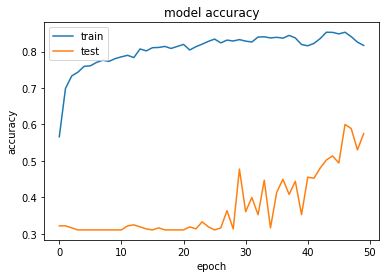

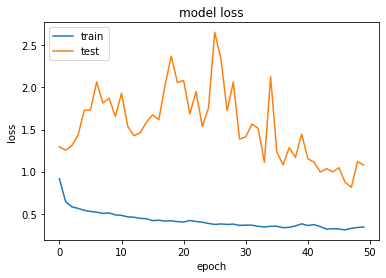

In [28]:
plot_hist(entirely_frozen_resnet50_history, 'entirely_frozen_resnet50_Adam')

#### saving the history of the fitting

In [29]:

with open(cwd + '/trainHistoryDict/basic_resnet50_history_Adam.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)


#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_resnet_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
 for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
# few_unfrozen_resnet_model.trainable = True
# trainable_count = 0

# set_trainable = False
# for layer in few_unfrozen_resnet_model.layers:
#     if layer.name == 'conv5_block1_1_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#         trainable_count += 1
#     else:
#         layer.trainable = False

# print('percent unfrozen:', trainable_count/ len(resnet_50.layers) * 100 , '%')

trainable_count = 0
per_layers = 0.2
num_model_layers = len(resnet_50.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

set_trainable = False
for idx, layer in enumerate(resnet_50.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False


true percentage of model trainable: 0.2


In [0]:
for layer in few_unfrozen_resnet_model.layers:
    print(layer.name,layer.trainable)

input_3 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_resnet_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/few_unfrozen_resnet50_Adam.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_resnet50_history = few_unfrozen_resnet_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 42s 2s/step - loss: 0.7531 - accuracy: 0.6552 - val_loss: 124.8978 - val_accuracy: 0.3528
Epoch 2/50
24/24 [==============================] - 37s 2s/step - loss: 0.5426 - accuracy: 0.7740 - val_loss: 613.3013 - val_accuracy: 0.3528
Epoch 3/50
24/24 [==============================] - 37s 2s/step - loss: 0.4730 - accuracy: 0.7976 - val_loss: 4.0801 - val_accuracy: 0.6083
Epoch 4/50
24/24 [==============================] - 37s 2s/step - loss: 0.4108 - accuracy: 0.8090 - val_loss: 3.6381 - val_accuracy: 0.3667
Epoch 5/50
24/24 [==============================] - 38s 2s/step - loss: 0.3886 - accuracy: 0.8281 - val_loss: 0.9005 - val_accuracy: 0.4444
Epoch 6/50
24/24 [==============================] - 37s 2s/step - loss: 0.3471 - accuracy: 0.8434 - val_loss: 2.3661 - val_accuracy: 0.3528
Epoch 7/50
24/24 [==============================] - 38s 2s/step - loss: 0.3154 - accur

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_resnet_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 3s 963ms/step - loss: 7.4381 - accuracy: 0.3417
model accuracy: 0.34166667


#### plotting training

In [0]:
pwd

'/content/drive/My Drive'

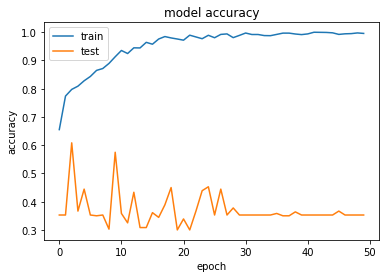

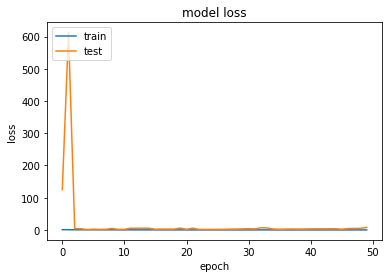

In [0]:
plot_hist(few_unfrozen_resnet50_history, 'few_unfrozen_resnet50_Adam')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/few_unfrozen_resnet50_history_Adam.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_resnet_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_4
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
# many_unfrozen_resnet_model.trainable = True
# trainable_count = 0

# set_trainable = False


# for layer in many_unfrozen_resnet_model.layers:
#     if layer.name == 'conv3_block1_1_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#         trainable_count += 1
#     else:
#         layer.trainable = False

# print('percent unfrozen:', trainable_count/ len(resnet_50.layers) * 100 , '%')
trainable_count = 0
per_layers = 0.7
num_model_layers = len(resnet_50.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

set_trainable = False
for idx, layer in enumerate(resnet_50.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

true percentage of model trainable: 0.7028571428571428


In [0]:
for layer in many_unfrozen_resnet_model.layers:
    print(layer.name,layer.trainable)

input_4 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_resnet_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/many_unfrozen_resnet50_Adam.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 

many_unfrozen_resnet50_history = many_unfrozen_resnet_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 58s 2s/step - loss: 0.8165 - accuracy: 0.6066 - val_loss: 45399.7565 - val_accuracy: 0.3528
Epoch 2/50
24/24 [==============================] - 52s 2s/step - loss: 0.6014 - accuracy: 0.7295 - val_loss: 2063.6222 - val_accuracy: 0.3528
Epoch 3/50
24/24 [==============================] - 51s 2s/step - loss: 0.5301 - accuracy: 0.7684 - val_loss: 4260.5868 - val_accuracy: 0.3528
Epoch 4/50
24/24 [==============================] - 52s 2s/step - loss: 0.4822 - accuracy: 0.7910 - val_loss: 78.5254 - val_accuracy: 0.4111
Epoch 5/50
24/24 [==============================] - 51s 2s/step - loss: 0.4475 - accuracy: 0.7990 - val_loss: 226.4782 - val_accuracy: 0.3861
Epoch 6/50
24/24 [==============================] - 52s 2s/step - loss: 0.4304 - accuracy: 0.8094 - val_loss: 6.6363 - val_accuracy: 0.5556
Epoch 7/50
24/24 [==============================] - 52s 2s/step - loss: 0.410

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_resnet_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 3s 976ms/step - loss: 5.3076 - accuracy: 0.5639
model accuracy: 0.5638889


#### plotting training

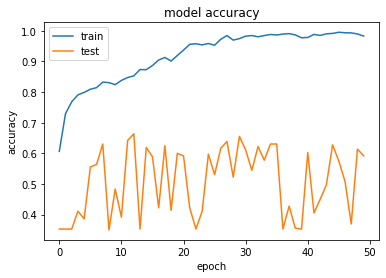

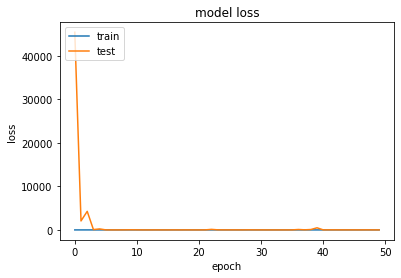

In [0]:
plot_hist(many_unfrozen_resnet50_history, 'many_unfrozen_resnet50_Adam')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/many_unfrozen_resnet50_history_Adam.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_resnet50_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
for layer in unfrozen_resnet50_model.layers:
    print(layer.name)
    layer.trainable = True

input_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
for layer in unfrozen_resnet50_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_5  Trainable = True
conv1_pad  Trainable = True
conv1_conv  Trainable = True
conv1_bn  Trainable = True
conv1_relu  Trainable = True
pool1_pad  Trainable = True
pool1_pool  Trainable = True
conv2_block1_1_conv  Trainable = True
conv2_block1_1_bn  Trainable = True
conv2_block1_1_relu  Trainable = True
conv2_block1_2_conv  Trainable = True
conv2_block1_2_bn  Trainable = True
conv2_block1_2_relu  Trainable = True
conv2_block1_0_conv  Trainable = True
conv2_block1_3_conv  Trainable = True
conv2_block1_0_bn  Trainable = True
conv2_block1_3_bn  Trainable = True
conv2_block1_add  Trainable = True
conv2_block1_out  Trainable = True
conv2_block2_1_conv  Trainable = True
conv2_block2_1_bn  Trainable = True
conv2_block2_1_relu  Trainable = True
conv2_block2_2_conv  Trainable = True
conv2_block2_2_bn  Trainable = True
conv2_block2_2_relu  Trainable = True
conv2_block2_3_conv  Trainable = True
conv2_block2_3_bn  Trainable = True
conv2_block2_add  Trainable = True
conv2_block2_out  Trainable =

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_resnet50_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/unfrozen_resnet50_Adam.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_resnet50_history = unfrozen_resnet50_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 72s 3s/step - loss: 0.8334 - accuracy: 0.6243 - val_loss: 3646.3311 - val_accuracy: 0.3528
Epoch 2/50
24/24 [==============================] - 65s 3s/step - loss: 0.5761 - accuracy: 0.7535 - val_loss: 953.2055 - val_accuracy: 0.3528
Epoch 3/50
24/24 [==============================] - 64s 3s/step - loss: 0.5238 - accuracy: 0.7788 - val_loss: 400.8180 - val_accuracy: 0.3528
Epoch 4/50
24/24 [==============================] - 65s 3s/step - loss: 0.4897 - accuracy: 0.7917 - val_loss: 26.7681 - val_accuracy: 0.4806
Epoch 5/50
24/24 [==============================] - 65s 3s/step - loss: 0.4673 - accuracy: 0.7920 - val_loss: 6.4161 - val_accuracy: 0.5639
Epoch 6/50
24/24 [==============================] - 65s 3s/step - loss: 0.4550 - accuracy: 0.7944 - val_loss: 5.5467 - val_accuracy: 0.6778
Epoch 7/50
24/24 [==============================] - 65s 3s/step - loss: 0.4186 - a

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_resnet50_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 3s 978ms/step - loss: 23.7246 - accuracy: 0.5444
model accuracy: 0.54444444


#### plotting training

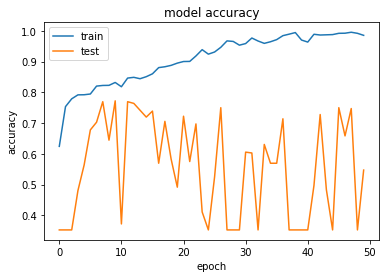

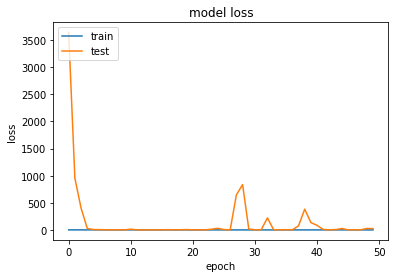

In [0]:
plot_hist(unfrozen_resnet50_history, 'unfrozen_resnet50_Adam')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/unfrozen_resnet50_history_Adam.p', 'wb') as file_pi:
        pickle.dump(unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved
